# PSUPR / PRMLS CA2

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
import lxml
import re
import os
import glob
import gensim
import time
import warnings
from collections import Counter

from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create a function for cleaning up tweets

In [10]:
# Init WordPunctTokenizer
tok = WordPunctTokenizer()
# create reg expression
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    # Use beautiful soup to decode html to text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # strip text using regular expression
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # strip to letters only
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # remove retweets handle
    removed_rt = re.sub('RT ','',letters_only)
    # set to lower case for all characters
    lower_case = removed_rt.lower()
    # Use tokenize to remove whitespace created by letters_only above
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

### Load Data from csv
Read all tweets from their respective csv and append everything into a single dataframe. Use directory name for their respective label.

In [11]:
dataset_directories = {
    'happy': '..\dataset\happy',
    'sad': '..\dataset\sad',
    'angry': '..\dataset\\angry',
}

def getTweetsFromCSV(directory):
    files = glob.glob(directory + '\*.csv')
    dfs = [pd.read_csv(f) for f in files]
    dfs_combined = pd.concat(dfs, ignore_index=True)
    return dfs_combined

In [12]:
%%time
dfs = []
for directory in dataset_directories:
    all_dfs = getTweetsFromCSV(dataset_directories[directory])
    all_dfs['label'] = directory
    dfs.append(all_dfs)

df_col = dfs[0].columns
final = pd.concat(dfs, ignore_index=True)
df = pd.DataFrame(final, columns=df_col)

Wall time: 428 ms


In [13]:
df.head()

,text,weekday,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name,label
0,RT @AntonioAntigna8: '\n\n brillia...,Fri,Sep,20,7,0,0,0,0,2,0,0,Antonio Antignani,AntonioAntigna8,happy
1,RT @AntonioAntigna8: '\n\n you\nhave\n ...,Fri,Sep,20,7,0,0,0,0,2,0,0,Antonio Antignani,AntonioAntigna8,happy
2,09.20.18 ~ the most magical night of my life 💜...,Fri,Sep,20,6,1,0,0,0,0,309,391,nisha🇨🇦💜🌸,nisha6240,happy
3,The #EUPHORIC Agbada \n#geteuphoric #euphorias...,Fri,Sep,20,6,1,1,0,0,0,733,814,EUPHORIA,Euphorianigeria,happy
4,RT @_kosmek_: The Euphoric Sound Is What Contr...,Fri,Sep,20,6,1,0,0,0,3,93,106,HaTi,Ha71_ES09,happy


In [14]:
df.shape

(40048, 15)

In [15]:
text = df['text']
label = df['label']
text.head()

0    RT @AntonioAntigna8: '\n\n             brillia...
1    RT @AntonioAntigna8: '\n\n      you\nhave\n   ...
2    09.20.18 ~ the most magical night of my life 💜...
3    The #EUPHORIC Agbada \n#geteuphoric #euphorias...
4    RT @_kosmek_: The Euphoric Sound Is What Contr...
Name: text, dtype: object

In [16]:
label.head()

0    happy
1    happy
2    happy
3    happy
4    happy
Name: label, dtype: object

### Clean up all tweets
Call the _tweet_cleaner_ method to process all tweets in the dataframe

In [18]:
%%time
cleaned_tweets = []
for tweet in text:
    cleaned_tweets.append(tweet_cleaner(tweet))
print((cleaned_tweets[:5]))
print(f'Tweets total: {len(cleaned_tweets)}')

['brilliant euphoric simply adrift', 'you have a thought rebel euphoric your', 'the most magical night of my life forevergrateful euphoric happyoneyearcandies', 'the euphoric agbada geteuphoric euphoriastylishman euphoriatrads', 'kosmek the euphoric sound is what controls me lahj jumpstyle hardjump euphoric hardstyle faded']
Tweets total: 40048
Wall time: 8.1 s


### Rejoin all tweets and remove duplicated tweets

In [19]:
finalDF = pd.DataFrame({'text': cleaned_tweets, 'label': label})
finalDF.drop_duplicates(subset='text', inplace=True, keep='first')

In [20]:
finalDF.shape

(20771, 2)

In [21]:
finalDF.head()

,text,label
0,brilliant euphoric simply adrift,happy
1,you have a thought rebel euphoric your,happy
2,the most magical night of my life forevergrate...,happy
3,the euphoric agbada geteuphoric euphoriastylis...,happy
4,kosmek the euphoric sound is what controls me ...,happy


### Display label distributions

Text(0.5, 1.0, 'Tweets Label Distro')

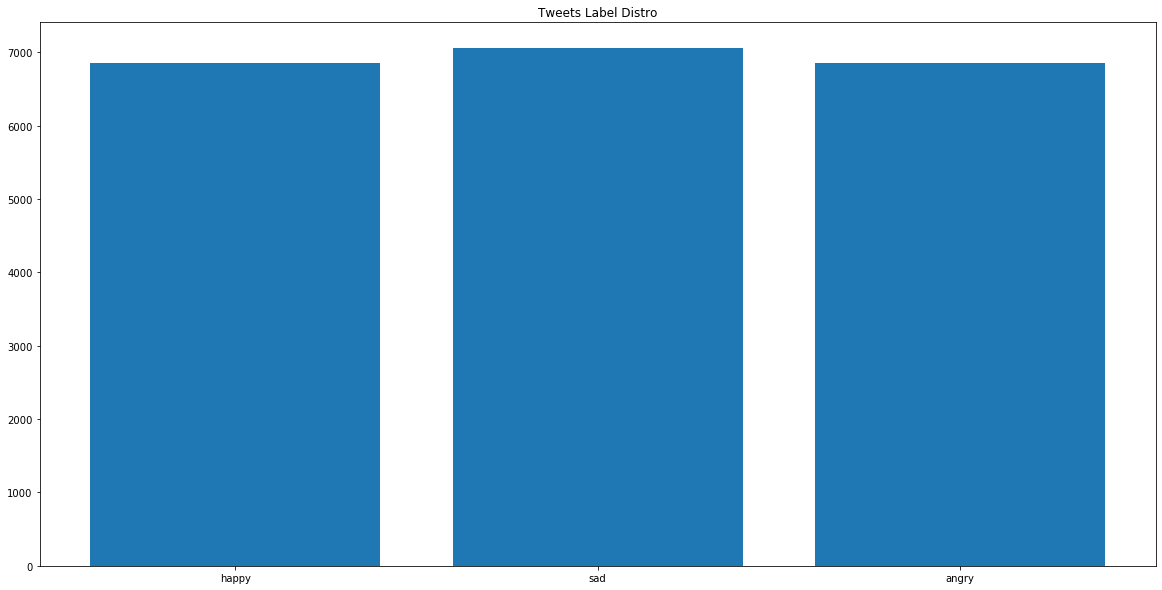

In [22]:
label_count = Counter(finalDF.label)

plt.figure(figsize=(20, 10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Tweets Label Distro')

### Preprocess Dataset

In [23]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [24]:
def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
%%time
finalDF.text = finalDF.text.apply(lambda x: preprocess(x))

Wall time: 557 ms


In [26]:
finalDF.iloc[0][0]

'brilliant euphoric simply adrift'

### Train, Test set split

In [27]:
X_train, X_test = train_test_split(finalDF, test_size=0.2, random_state=42)

In [28]:
X_train.head()

,text,label
26389,carlson cut hurt,sad
3236,sad realdonaldtrump faketweets wall built vict...,happy
33468,happy birthday one third hot tempered triad th...,angry
33958,robbie henshaw doubt ireland world cup opener ...,angry
28974,heated argument takes cut lives short place ad...,angry


In [29]:
%%time
documents = [_text.split() for _text in X_train.text]

Wall time: 35.5 ms


In [30]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,
                                            window=7,
                                           min_count=10,
                                           workers=8)

In [31]:
%%time
w2v_model.build_vocab(documents)

Wall time: 586 ms


In [32]:
words = w2v_model.wv.vocab.keys()
vocab_size=len(words)
print("Vocab size:", vocab_size)

Vocab size: 2523


In [33]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

Wall time: 3.39 s


(3249939, 5083872)

In [36]:
# Check for similar words
w2v_model.most_similar("happy")

[('bday', 0.6744366884231567),
 ('wishing', 0.6478131413459778),
 ('tuesday', 0.6401486396789551),
 ('birthday', 0.592665433883667),
 ('everyday', 0.5803666114807129),
 ('minister', 0.5638066530227661),
 ('energy', 0.5354979038238525),
 ('proud', 0.5294118523597717),
 ('friday', 0.5291744470596313),
 ('grateful', 0.5226333737373352)]

### Tokenize Text

In [37]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 28471
Wall time: 341 ms


In [38]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test.text), maxlen=300)

Wall time: 409 ms


In [39]:
labels = finalDF.label.unique().tolist()
labels

['happy', 'sad', 'angry']

In [41]:
encoder = LabelEncoder()
encoder.fit(X_train.label.tolist())

y_train = encoder.transform(X_train.label.tolist())
y_test = encoder.transform(X_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train_labels = to_categorical(y_train, num_classes=3)
y_test_labels = to_categorical(y_test, num_classes=3)
len(y_test_labels)

y_train (16616, 1)
y_test (4155, 1)


4155

In [42]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16616, 300)
y_train (16616, 1)

x_test (4155, 300)
y_test (4155, 1)


In [43]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(28471, 300)


In [44]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [46]:
model = Sequential()
model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.add(embedding_layer)
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(24, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          8541300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 296, 32)           48032     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 148, 200)          106400    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 148, 200)          240800    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 24)                4824      
__________

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [48]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train_labels,
                    batch_size=32,
                    epochs=25,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 14954 samples, validate on 1662 samples
Epoch 1/25
14954/14954 [==============================] - 1234s 83ms/step - loss: 0.6443 - acc: 0.7108 - val_loss: 0.5173 - val_acc: 0.7575
Epoch 2/25
14954/14954 [==============================] - 1244s 83ms/step - loss: 0.4974 - acc: 0.7756 - val_loss: 0.5011 - val_acc: 0.7810
Epoch 3/25
 8160/14954 [===============>..............] - ETA: 4:33 - loss: 0.4561 - acc: 0.7991

In [72]:
%%time
# len(X_test)
score = model.evaluate(x_test, y_test_labels, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])
# y_test_labels

2036/2036 [==============================] - 43s 21ms/step

ACCURACY: 0.7583497054216202
LOSS: 0.5079253493334315
Wall time: 43 s


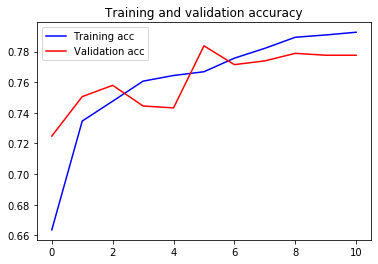

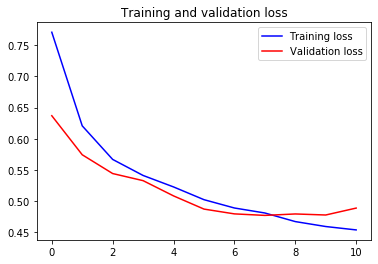

In [73]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [67]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [58]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
# plt.figure(figsize=(12,12))
# plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
# plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)